In [1]:
import os, sys
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import logging
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc_context

warnings.filterwarnings('ignore', category=FutureWarning)

sc.set_figure_params(dpi=100, color_map='viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.9.5 anndata==0.10.1 umap==0.5.4 numpy==1.24.1 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 pynndescent==0.5.10


In [2]:
ad_sc = sc.read(
#    "F:\Desktop github\Bioinformatics\sc_Data\Mop\mop_sn_tutorial.h5ad",
    "/home/zbdc/github/sc_Data/Mop/mop_sn_tutorial.h5ad",
    cache=True
)
ad_sc

AnnData object with n_obs × n_vars = 26431 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [3]:
ad_sp = sc.read(
#    "F:\Desktop github\Bioinformatics\sc_Data\Mop\slideseq_MOp_1217.h5ad",
    "/home/zbdc/github/sc_Data/Mop/slideseq_MOp_1217.h5ad",
    cache=True
)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

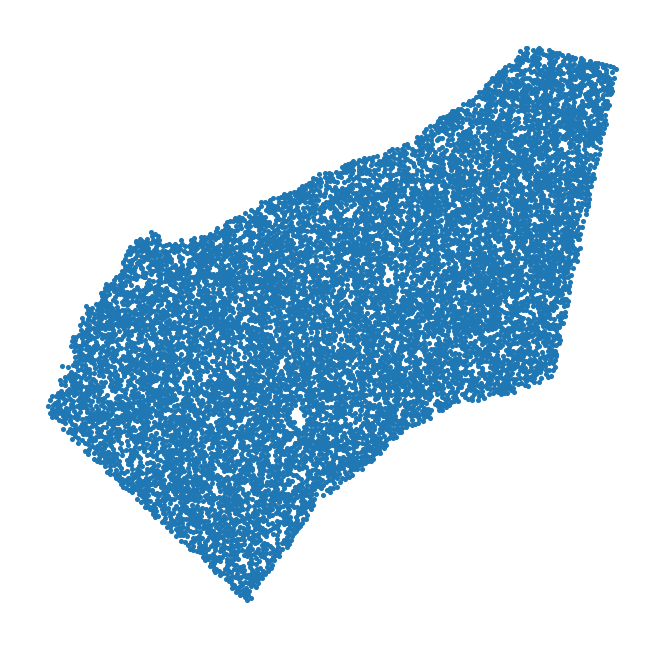

In [4]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7)
plt.gca().invert_yaxis()

In [5]:
df_genes = pd.read_csv('/home/zbdc/github/sc_Data/Mop/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

253

In [6]:
from zbdc import pp_sc_datas as pp_adatas
import zbdc.__init__

pp_adatas(
    adata_sc=ad_sc, 
    adata_sp=ad_sp,
    marker_genes=markers,
)

INFO:root:18000 overlap genes genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:18000 training genes genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior ACCGGAACTTCTTC    0.000102
GGGGGGGGGGGGGG    0.000102
AAAGACCCAAAGGC    0.000102
TCGGCGGTATCATT    0.000102
TACGCCGGTACTGG    0.000102
                    ...   
CAGTTGTGGAGCAG    0.000102
ACTATGGTGTATCA    0.000102
CACCCCCTAGAAAT    0.000102
AAAGAATACGTACC    0.000102
TATTTGGGTTATTT    0.000102
Name: uniform_density, Length: 9852, dtype: float64 is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior ACCGGAACTTCTTC    0.001707
GGGGGGGGGGGGGG    0.002651
AAAGACCCAAAGGC    0.001267
TCGGCGGTATCATT    0.001244
TACGCCGGTACTGG    0.001302
                    ...   
CAGTTGTGGAGCAG    0.000001
ACTATGGTGTATCA    0.000001
CACCCCCTAGAAAT    0.000001
AAAGAATACGTACC    0.000001
TAT

In [7]:
sc.pp.normalize_total(ad_sc, target_sum=1)
sc.pp.normalize_total(ad_sp, target_sum=1)

In [8]:
assert ad_sc.uns['training_genes'] == ad_sp.uns['training_genes']

In [9]:
import zbdc.mapping_utils   

ad_map = zbdc.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=ad_sp,
  # device='cpu',
    mode="cells",
    learning_rate=0.1,
    num_epochs=1000,
    lambda_a=1.0,
    lambda_d=1.0,
    lambda_r=0,
    density_prior="rna_count_based",
    device='cuda:0',
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 18000 genes...
INFO:root:Printing scores every 100 epochs.


Epoch 1, loss = -0.2562742531299591, gv_term = 0.19006669521331787, vg_term = 0.06623434275388718, density term = 2.679252065718174e-05, res term = -0.0
Epoch 2, loss = -0.25664371252059937, gv_term = 0.19013965129852295, vg_term = 0.06652772426605225, density term = 2.3677945137023926e-05, res term = -0.0
Epoch 3, loss = -0.2570275366306305, gv_term = 0.19021320343017578, vg_term = 0.06683686375617981, density term = 2.2526539396494627e-05, res term = -0.0
Epoch 4, loss = -0.2574278712272644, gv_term = 0.19028744101524353, vg_term = 0.06716349720954895, density term = 2.3079221136868e-05, res term = -0.0
Epoch 5, loss = -0.257846862077713, gv_term = 0.1903623789548874, vg_term = 0.06750957667827606, density term = 2.5098153855651617e-05, res term = -0.0
Epoch 6, loss = -0.2582870423793793, gv_term = 0.19043807685375214, vg_term = 0.06787733733654022, density term = 2.8384733013808727e-05, res term = -0.0
Epoch 7, loss = -0.2587510943412781, gv_term = 0.19051460921764374, vg_term = 0.0

INFO:root:Saving results..
